In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [13]:
conn = psycopg2.connect(database="keep_data", user="postgres", password="postgres", host="localhost", port="5432")
cur = conn.cursor()
df = psql.read_sql("Select * from markets_data", conn)
df.sort_values(by='time',inplace=True)
del df['time']
df.tail()

,open_b,close_b,high_b,low_b,vol_b,vol_conv_b,open,close,high,low,vol,vol_conv,average,cnt
104,0.002199,0.002186,0.002346,0.002021,98054.12,213.790432,0.978701,0.923203,0.990962,0.891322,1.781477e+06,1.713023e+06,0.961575,623
105,0.002186,0.002164,0.002391,0.002053,49811.96,107.088842,0.975837,1.063328,1.097694,0.949114,1.609289e+06,1.604704e+06,0.997151,425
106,0.002408,0.002552,0.002617,0.002408,21217.45,54.298460,1.042762,1.228240,1.255822,1.041112,1.803596e+06,2.084734e+06,1.155876,346
107,0.002925,0.002448,0.002936,0.002331,63935.64,170.425915,1.217558,0.986756,1.269761,0.972522,1.284315e+06,1.450917e+06,1.129721,496
108,0.002448,0.002433,0.002454,0.002247,76201.35,185.126326,1.048388,0.948970,1.073593,0.909553,9.768754e+05,9.657420e+05,0.988603,341


In [14]:
data_unsc = df.values
data = df.values
#data_norm = data
data_normaliser = preprocessing.MinMaxScaler()
data_norm = data_normaliser.fit_transform(data)

In [29]:
history_points = 60
pred_candel = 1

ohlcv_histories = np.array([data_norm[i:i + history_points].copy() for i in range(len(data_norm) - history_points-pred_candel)])
next_day_open_values = np.array([data_norm[:, 2][i + history_points+pred_candel].copy() for i in range(len(data_norm) - history_points-pred_candel)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

next_day_open_values_unsc = np.array([data_unsc[:, 2][i + history_points+pred_candel].copy() for i in range(len(data_unsc) - history_points-pred_candel)])
next_day_open_values_unsc = np.expand_dims(next_day_open_values_unsc, -1)

y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values_unsc)

test_split = 0.5
n = int(ohlcv_histories.shape[0] * test_split)
ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]
ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = next_day_open_values_unsc[n:]

ohlcv_train = np.reshape(ohlcv_train,(ohlcv_train.shape[0],ohlcv_train.shape[1]*ohlcv_train.shape[2],1))
ohlcv_test = np.reshape(ohlcv_test,(ohlcv_test.shape[0],ohlcv_test.shape[1]*ohlcv_test.shape[2],1))
ohlcv_train = np.reshape(ohlcv_train,(ohlcv_train.shape[0],ohlcv_train.shape[1]*ohlcv_train.shape[2]))
ohlcv_test = np.reshape(ohlcv_test,(ohlcv_test.shape[0],ohlcv_test.shape[1]*ohlcv_test.shape[2]))

In [16]:
ohlcv_train.shape


(48, 840)

In [26]:
from tensorflow import keras
model = keras.Sequential([

    keras.layers.Dense(1500,input_dim=ohlcv_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='linear')
])

opt = keras.optimizers.Adam(learning_rate=0.0005,decay=1e-6,)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1500)              1261500   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1500)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1500)              6000      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               750500    
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               2000      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

In [27]:
history = model.fit(ohlcv_train, y_train, epochs=1000,batch_size=100,validation_split=0.2)

Epoch 1/1000
1/1 [==============================] - 0s 276ms/step - loss: 1.9218 - mae: 1.1330 - val_loss: 0.0494 - val_mae: 0.2150
Epoch 2/1000
1/1 [==============================] - 0s 38ms/step - loss: 2.1444 - mae: 1.2234 - val_loss: 0.0690 - val_mae: 0.2553
Epoch 3/1000
1/1 [==============================] - 0s 40ms/step - loss: 1.7044 - mae: 0.9224 - val_loss: 0.1079 - val_mae: 0.3222
Epoch 4/1000
1/1 [==============================] - 0s 39ms/step - loss: 2.7368 - mae: 1.3434 - val_loss: 0.0916 - val_mae: 0.2957
Epoch 5/1000
1/1 [==============================] - 0s 39ms/step - loss: 1.7758 - mae: 1.0575 - val_loss: 0.0769 - val_mae: 0.2709
Epoch 6/1000
1/1 [==============================] - 0s 39ms/step - loss: 1.5179 - mae: 1.0064 - val_loss: 0.0714 - val_mae: 0.2610
Epoch 7/1000
1/1

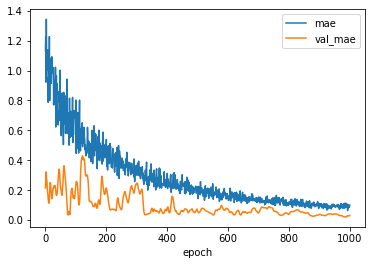

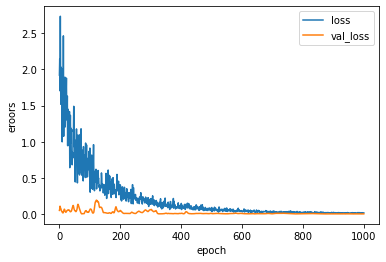

In [28]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('eroors')
plt.legend()
plt.show()

1/1 [==============================] - 0s 5ms/step - loss: 9.7760e-04 - mae: 0.0258
Test metrics
MSE: 1.3026065266675943e-06
MAE: 0.0010744690727330496
MAPE: 37.7890129582628


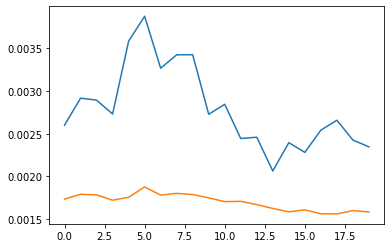

In [30]:
predictions = model.predict(ohlcv_test)
evaluate = model.evaluate(ohlcv_test,y_test)
predictions = y_normaliser.inverse_transform(predictions)
mse = np.mean(np.square(unscaled_y_test - predictions))
mae = np.sum(np.absolute((unscaled_y_test - predictions)))/len(unscaled_y_test)
mape = np.mean(np.abs((unscaled_y_test - predictions) / unscaled_y_test)) * 100
print("Test metrics")
print('MSE:',mse)
print('MAE:',mae)
print('MAPE:',mape)
s_plot = 0
e_plot = 20
plt.plot(unscaled_y_test[s_plot:e_plot])
plt.plot(predictions[s_plot:e_plot])

In [12]:
model.save("models\keep_predit_simple.h5")


